In [1]:
%%capture
#!pip install hdbscan
#!pip install clusteval
#!pip install umap-learn

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

#import plotly_express as px
import plotly.graph_objs as go
#import plotly.plotly as py
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#import umap
#import umap.umap_ as umap

import numpy as np
import networkx as nx
from tqdm.notebook import tqdm
import pickle
import time

from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

#from clusteval import clusteval


In [3]:
'''
from google.colab import drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/Colab Notebooks/Projects/L2C4/"
'''

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\nproject_path = "/content/drive/MyDrive/Colab Notebooks/Projects/L2C4/"\n'

In [4]:
project_path = ""

In [5]:
'''
%%capture
!wget https://raw.githubusercontent.com/sarthakrastogi/L2C4/main/clustering.py
!wget https://raw.githubusercontent.com/sarthakrastogi/L2C4/main/clustering_optimal_algos.py
'''

'\n%%capture\n!wget https://raw.githubusercontent.com/sarthakrastogi/L2C4/main/clustering.py\n!wget https://raw.githubusercontent.com/sarthakrastogi/L2C4/main/clustering_optimal_algos.py\n'

In [6]:
'''
%%capture
!pip install chart_studio
!pip install clusteval

import chart_studio.plotly as py
import plotly.graph_objs as go
'''

'\n%%capture\n!pip install chart_studio\n!pip install clusteval\n\nimport chart_studio.plotly as py\nimport plotly.graph_objs as go\n'

In [7]:
def make_df(graph):
    df = pd.DataFrame(list(graph.items()))

    df.rename(columns = {0:'word', 1:'vector'}, inplace = True)
    df[[i for i in range(0, 50)]] = pd.DataFrame(df['vector'].tolist(), index=df.index)
    df.drop('vector', axis=1, inplace=True)
    
    df = df.drop('word', axis=1)

    return df


def apply_pca(df):
    pca = PCA(n_components=25)
    res = pca.fit_transform(df)
    print("Explained variance:", pca.explained_variance_ratio_.sum())
    return res


def apply_tsne(df):#, perplexity, n_iter):
    tsne = TSNE(n_components=2)#, perplexity=perplexity, n_iter=n_iter)
    v2d = tsne.fit_transform(df)
    return v2d


def apply_umap(df):
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(df)
    #print(reducer.explained_variance_ratio_.sum())
    return embedding


def apply_svd(df):
    
    u, s, v = np.linalg.svd(df, full_matrices=True)
    print(np.round(s**2/np.sum(s**2), decimals=3))
    labels= ['SV'+str(i) for i in range(1,3)]
    svd_df = pd.DataFrame(u[:,0:2], 
                          #index=lifeExp_meta["continent"].tolist(), 
                          columns=labels)
    #svd_df=svd_df.reset_index()
    #svd_df.drop('index', inplace=True, axis=1)
    return svd_df.values

def clustevalres(X):
    ce = clusteval(evaluate='silhouette')
    ce.fit(X)
    #ce.plot()
    #ce.dendrogram()
    ce.scatter(X)

    ce = clusteval(evaluate='dbindex')
    ce.fit(X)
    #ce.plot()
    ce.scatter(X)
    #ce.dendrogram()

    ce = clusteval(cluster='dbscan')
    try:
        ce.fit(X)
        ce.plot()
        ce.scatter(X)
    except ValueError:
        pass
    #ce.dendrogram()

    ce = clusteval(cluster='hdbscan')
    ce.fit(X)
    #ce.plot()
    ce.scatter(X)
    #ce.dendrogram()

    
def vary_damping(graph, algo):
    best_damping = 0
    max_sil = 0
    for damping in [0.5, 0.6, 0.7, 0.8, 0.9]:
        if True:#try:
            sil, pct = algo(graph, damping=damping)
        #except ValueError:
         #   pass
        
        if sil > max_sil:
            max_sil = sil
            best_damping = damping

    return best_damping

        
def vary_n_of_clusters(graph, algo):
    best_n = 0
    max_sil = 0
    for n in range(6, 20):
        sil, pct = algo(graph, n)
        
        if sil > max_sil:
            max_sil = sil
            best_n = n
    return best_n
  
        
        
def vary_min_samples(graph, algo):
    best_n = 0
    max_sil = 0
    for n in range(4, 15):
        sil, pct = (graph, n)
        
        if sil > max_sil:
            max_sil = sil
            best_n=n
    return best_n


def make_tensors(graph):
    import torch
    return {k : torch.FloatTensor(v).to(cuda) for k, v in graph.items()}

In [8]:
#project_path = ""

In [9]:
def load_graph(lang1, lang2):
    with open(project_path + "Graphs/" + str(lang1) + "_" + str(lang2) + "_" + "graph.pickle", 'rb') as f:
        return pickle.load(f)

------

# 1. Samskrit and Latin

In [10]:
sa_la_graph = load_graph('sa', 'la')
df = apply_tsne(apply_pca(make_df(sa_la_graph)))

Explained variance: 0.8544635623438387


In [11]:
import warnings
warnings.filterwarnings("ignore")


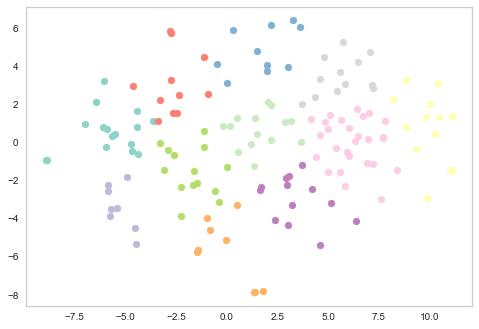

Sillhouette score:  0.5190862404818947
Percentage score:  0.7595431202409473
Number of clusters:  11


In [12]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

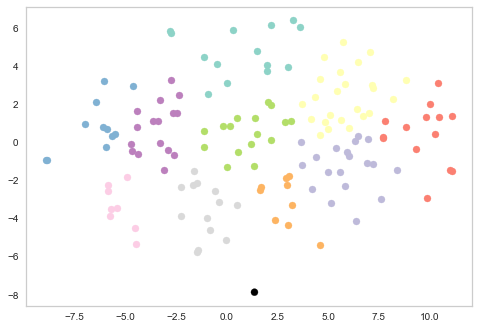

Sillhouette score:  0.5052328639363342
Percentage score:  0.7526164319681671
Number of clusters:  11
11


In [13]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)
print(n)

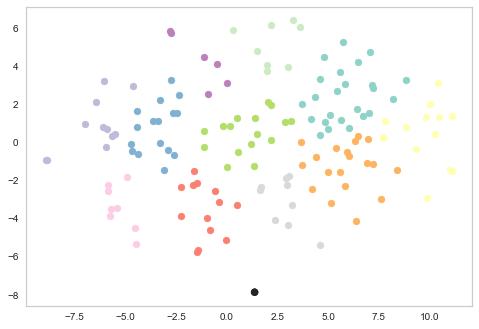

Sillhouette score:  0.5027730168497726
Percentage score:  0.7513865084248863
Number of clusters:  12
12


In [14]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)
print(n)

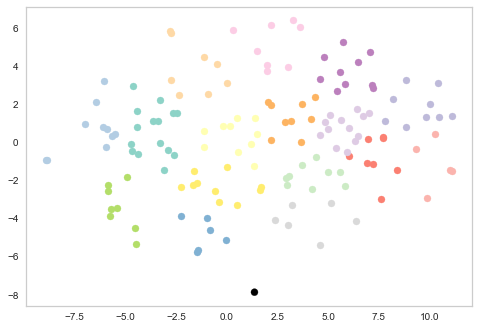

Sillhouette score:  0.5140489777551999
Percentage score:  0.7570244888775999
Number of clusters:  17
17


In [15]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)
print(n)

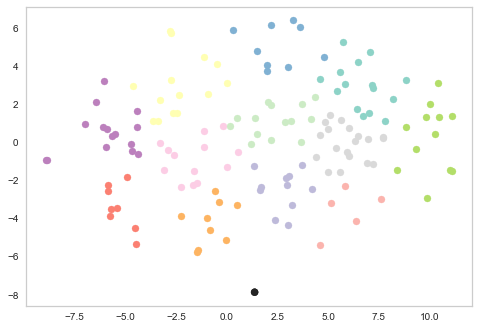

Sillhouette score:  0.5313820966936877
Percentage score:  0.7656910483468439
Number of clusters:  13


In [16]:
vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

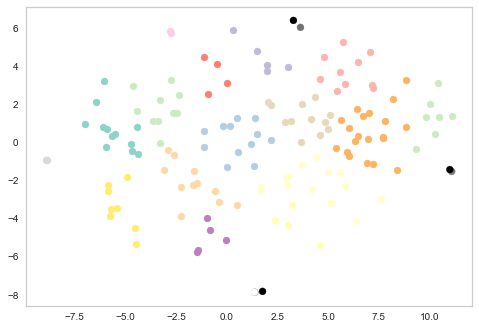

Sillhouette score:  0.5060998454040323
Percentage score:  0.7530499227020162
Number of clusters:  19


In [17]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

In [18]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

---

# 2. Samskrit and Hindi

In [19]:
sa_hi_graph = load_graph('sa', 'hi')
df = apply_tsne(apply_pca(make_df(sa_hi_graph)))

Explained variance: 0.7953388277970651


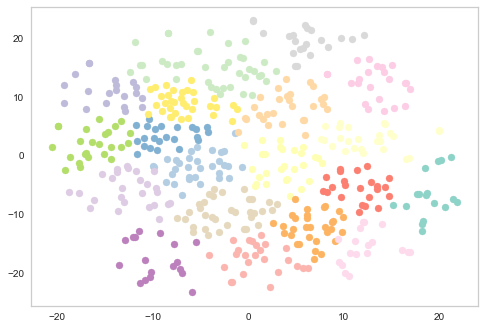

Sillhouette score:  0.5098409848835882
Percentage score:  0.754920492441794
Number of clusters:  20


In [20]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

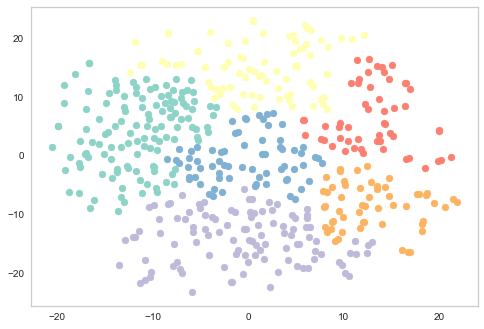

Sillhouette score:  0.43634922618369115
Percentage score:  0.7181746130918456
Number of clusters:  6


In [21]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)

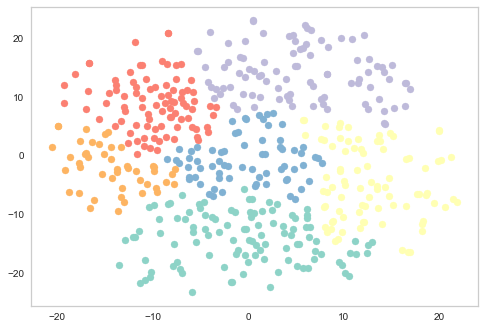

Sillhouette score:  0.4477097333830549
Percentage score:  0.7238548666915274
Number of clusters:  6


In [22]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)

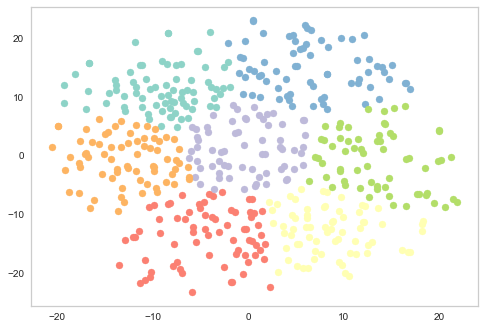

Sillhouette score:  0.5258174052754422
Percentage score:  0.762908702637721
Number of clusters:  7


In [23]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)

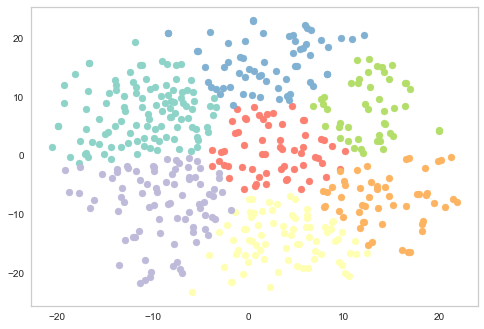

Sillhouette score:  0.5056959014747822
Percentage score:  0.7528479507373911
Number of clusters:  7


In [24]:
vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

In [25]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

ValueError: k must be greater than 0.

In [26]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

---

# 3. Hindi and English

In [27]:
hi_en_graph = load_graph('hi', 'en')
df = apply_tsne(apply_pca(make_df(hi_en_graph)))

Explained variance: 0.7515722028205142


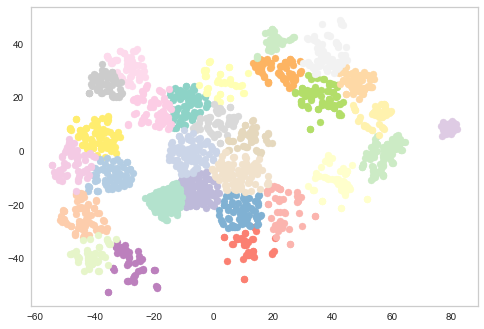

Sillhouette score:  0.5401041095534335
Percentage score:  0.7700520547767167
Number of clusters:  44


In [28]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = 0.9#vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

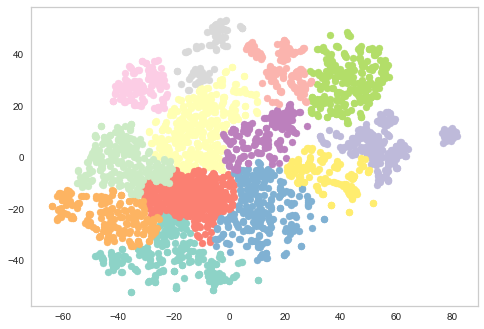

Sillhouette score:  0.4636265427882921
Percentage score:  0.7318132713941461
Number of clusters:  13


In [29]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)

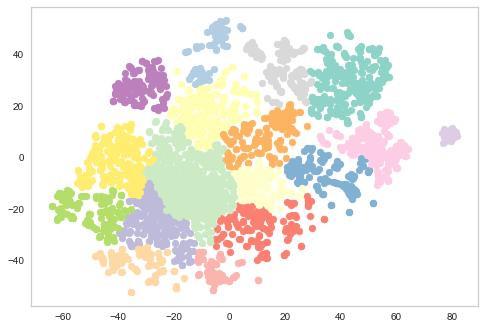

Sillhouette score:  0.48306177081657187
Percentage score:  0.7415308854082859
Number of clusters:  18


In [30]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)

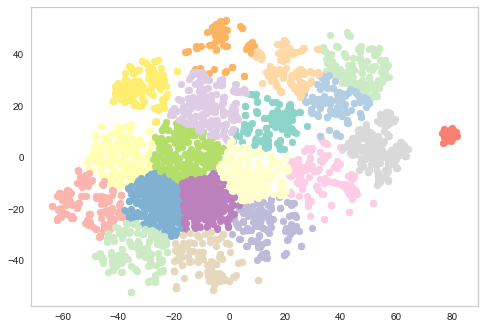

Sillhouette score:  0.558917722820879
Percentage score:  0.7794588614104395
Number of clusters:  19


In [31]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)

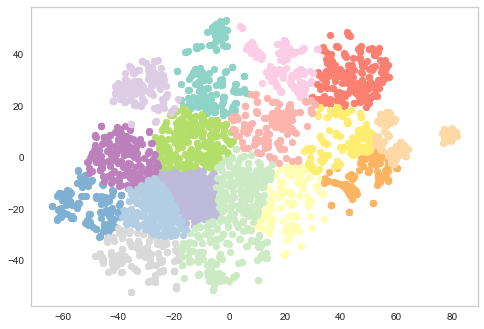

Sillhouette score:  0.5133149173150725
Percentage score:  0.7566574586575363
Number of clusters:  17


In [32]:
vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

In [34]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

# 4. German and English

In [36]:
de_en_graph = load_graph('de', 'en')
df = apply_tsne(apply_pca(make_df(de_en_graph)))

Explained variance: 0.7590159340013757


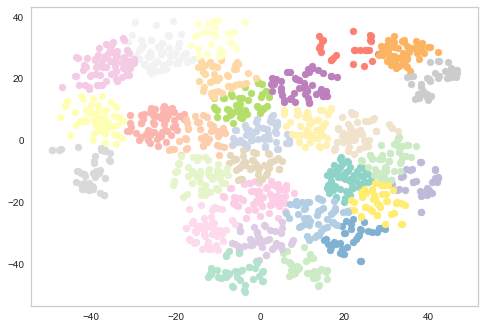

Sillhouette score:  0.5208770156328831
Percentage score:  0.7604385078164415
Number of clusters:  38


In [37]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = 0.8# vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

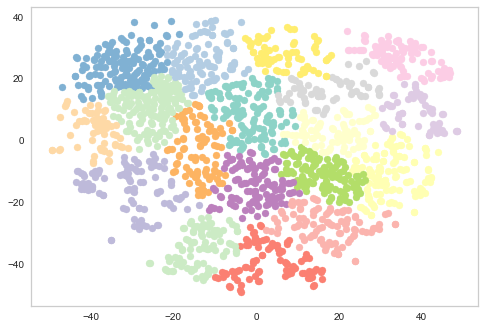

Sillhouette score:  0.4521568146916965
Percentage score:  0.7260784073458483
Number of clusters:  18


In [38]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)

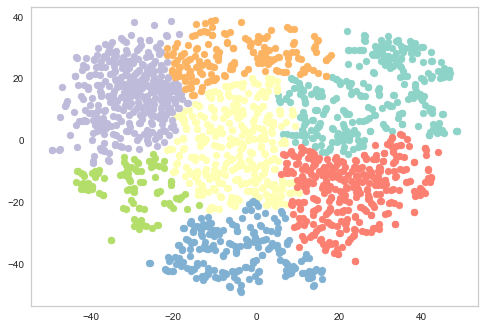

Sillhouette score:  0.4651328631917156
Percentage score:  0.7325664315958578
Number of clusters:  7


In [39]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)

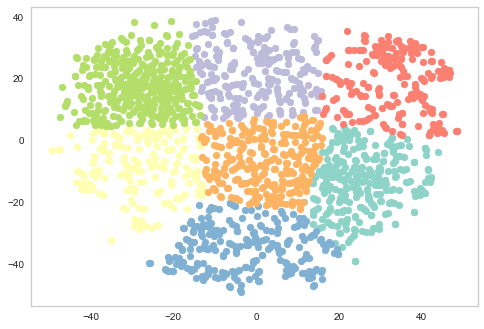

Sillhouette score:  0.5533024203695066
Percentage score:  0.7766512101847534
Number of clusters:  7


In [40]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)

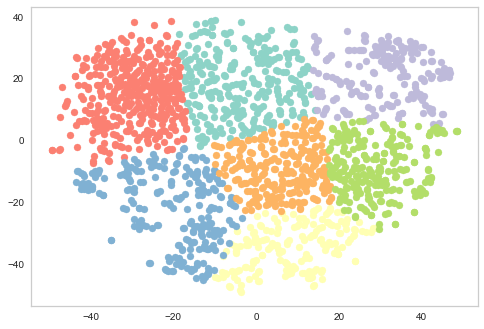

Sillhouette score:  0.5161140916858313
Percentage score:  0.7580570458429157
Number of clusters:  7


In [41]:
vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

In [42]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

KeyboardInterrupt: 

In [43]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

---

# 5. Latin and English

In [44]:
la_en_graph = load_graph('la', 'en')
df = apply_tsne(apply_pca(make_df(la_en_graph)))

Explained variance: 0.7636619697691124


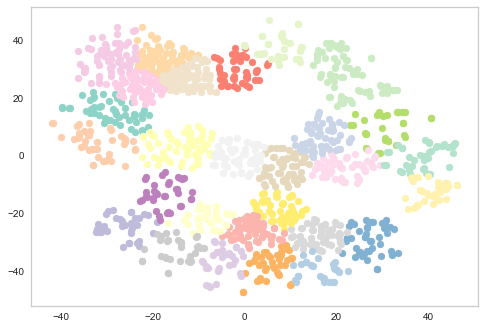

Sillhouette score:  0.4877304967662131
Percentage score:  0.7438652483831065
Number of clusters:  39


In [45]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = 0.8#vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

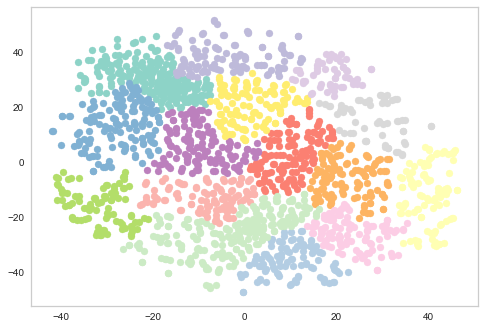

Sillhouette score:  0.4290821360857593
Percentage score:  0.7145410680428796
Number of clusters:  16


In [46]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)

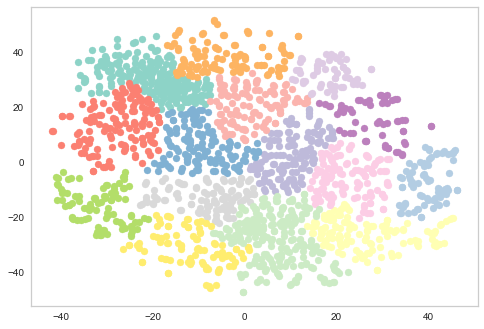

Sillhouette score:  0.4316480740061001
Percentage score:  0.7158240370030501
Number of clusters:  16


In [47]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)

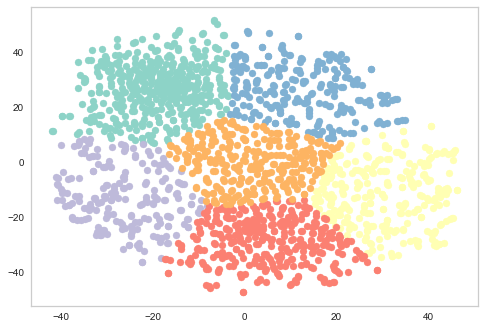

Sillhouette score:  0.5570587533855829
Percentage score:  0.7785293766927914
Number of clusters:  6


In [48]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)

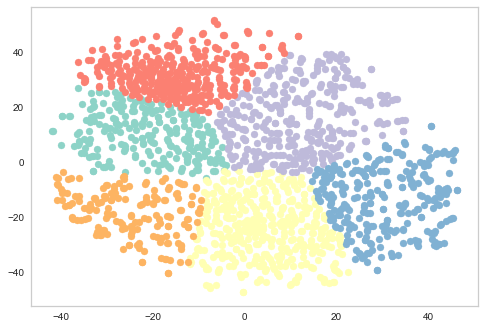

Sillhouette score:  0.5039607417681201
Percentage score:  0.75198037088406
Number of clusters:  6


In [49]:
vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

In [50]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

KeyboardInterrupt: 

In [51]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

---

# 6. Latin and French

In [52]:
la_fr_graph = load_graph('la', 'fr')
df = apply_tsne(apply_pca(make_df(la_fr_graph)))

Explained variance: 0.7769167711441057


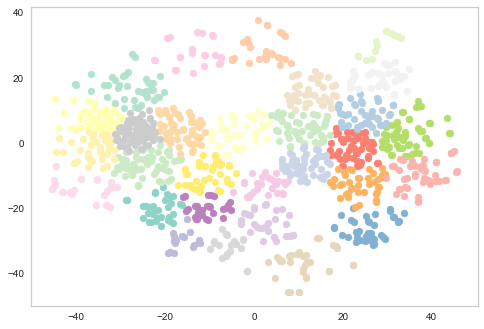

Sillhouette score:  0.5018600688499275
Percentage score:  0.7509300344249638
Number of clusters:  34


In [53]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = 0.9# vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

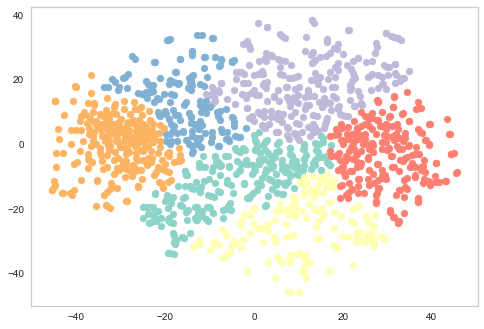

Sillhouette score:  0.4482659840476032
Percentage score:  0.7241329920238015
Number of clusters:  6


In [54]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)

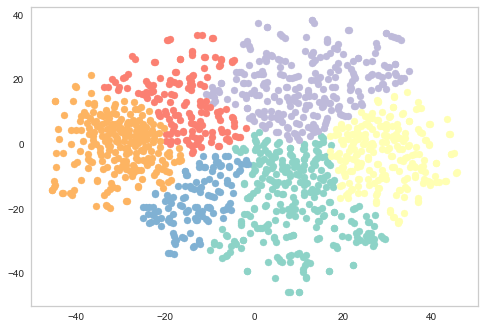

Sillhouette score:  0.4255827691737922
Percentage score:  0.7127913845868961
Number of clusters:  6


In [55]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)

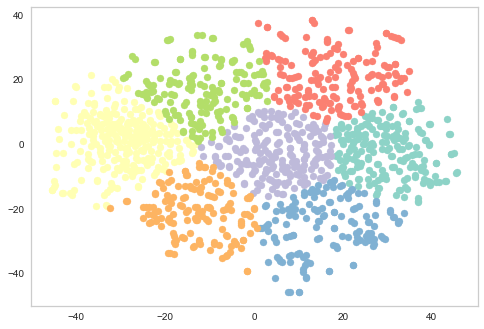

Sillhouette score:  0.5457623028207108
Percentage score:  0.7728811514103554
Number of clusters:  7


In [56]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)

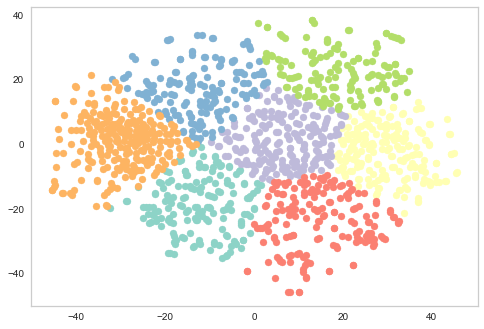

Sillhouette score:  0.5307378989631625
Percentage score:  0.7653689494815812
Number of clusters:  7


In [57]:
vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

In [58]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

---

# 7. Hindi and Tamil

In [59]:
hi_ta_graph = load_graph('hi', 'ta')
df = apply_tsne(apply_pca(make_df(hi_ta_graph)))

Explained variance: 0.7646960238862928


In [60]:
#clustevalres(df)

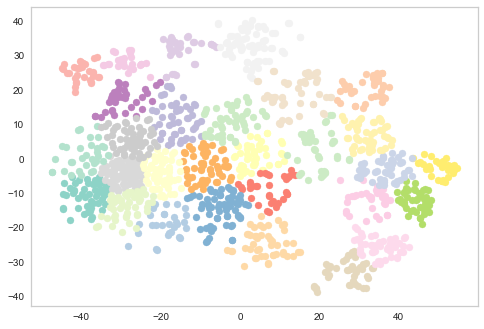

Sillhouette score:  0.5388223456110454
Percentage score:  0.7694111728055226
Number of clusters:  32


In [61]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

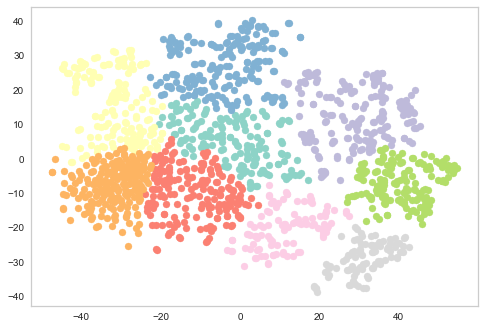

Sillhouette score:  0.5106544775726685
Percentage score:  0.7553272387863342
Number of clusters:  9


In [62]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)

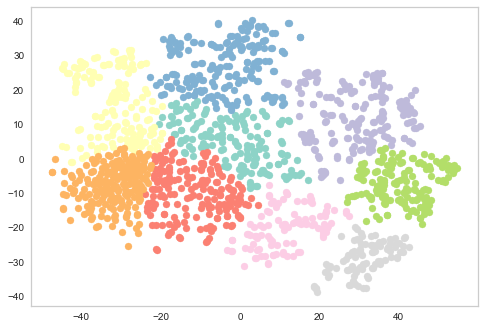

Sillhouette score:  0.5106544775726685
Percentage score:  0.7553272387863342
Number of clusters:  9


In [63]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)

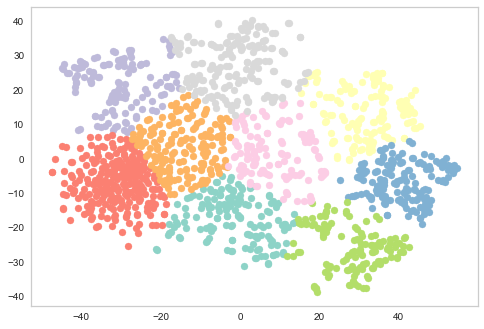

Sillhouette score:  0.5675100619259111
Percentage score:  0.7837550309629555
Number of clusters:  9


In [64]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)

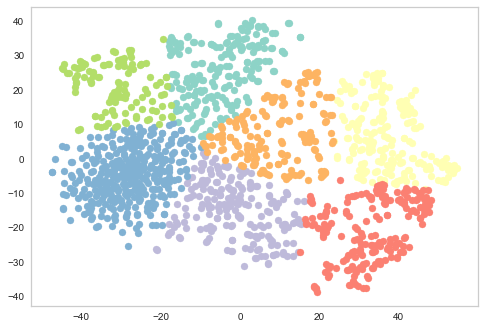

Sillhouette score:  0.5424430662953653
Percentage score:  0.7712215331476826
Number of clusters:  7


In [65]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

In [66]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

---

'https://machinelearningmastery.com/clustering-algorithms-with-python/'